<a href="https://colab.research.google.com/github/benstream/CS-311/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import geopandas as gpd
import glob
import os
from matplotlib import colormaps
import matplotlib.pyplot as plt
import datetime
import sys
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Set Drive to directitory and make sure CSV files are there\
%cd /content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical\ Data/Fire_Weather_Data/akff_data

%ls

/content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical Data/Fire_Weather_Data/akff_data
akff_data_combined.csv             mesowest_psa10.csv   PAJZ_akff_data.csv
AKFF_Data_for_R.csv                missing_data/        PAKF_akff_data.csv
ALSA2_akff_data.csv                MOGA2_akff_data.csv  PANW_akff_data.csv
BLAA2_akff_data.csv                N15KX_akff_data.csv  PAPH_akff_data.csv
CONA2_akff_data.csv                N18KX_akff_data.csv  PAPN_akff_data.csv
COVA2_akff_data.csv                O14KX_akff_data.csv  PAPN_akff_data.gsheet
earliest_akff_data_by_station.csv  P17KX_akff_data.csv  PASD_akff_data.csv
FAFA2_akff_data.csv                PADL_akff_data.csv   station-availability02-16-2024.csv
FPKA2_akff_data.csv                PAIG_akff_data.csv   station-availability02-20-2024.csv
KILA2_akff_data.csv                PAIL_akff_data.csv   station-availability02-20-2024.xlsx
KILA2_akff_data.gsheet             PAJC_akff_data.csv   SVRA2_akff_data.csv


In [20]:
# Read in CSV File(s)

months = [5, 6, 7, 8, 9]
today = datetime.date.today().strftime("%m-%d-%Y")


path = './' # use your path
all_files_stats = glob.glob(os.path.join(path, "*_data.csv"))
df_stats = pd.concat((pd.read_csv(f, comment='!',usecols=['NAME','STATIONID','DATE','ATF','FWI'],parse_dates=['DATE']) for f in all_files_stats), ignore_index=True)

# Creater a reference to use NWSFIREZONE
df_station_info = pd.read_csv('./mesowest_psa10.csv',usecols=['stid','NWSFIREZONE','MNET_SHORTNAME'])
station_firezone = dict(zip(df_station_info['stid'],df_station_info['NWSFIREZONE']))
station_provider = dict(zip(df_station_info['stid'],df_station_info['MNET_SHORTNAME']))


df_stats.loc[:,'day'] = df_stats.loc[:,'DATE'].dt.dayofyear
df_stats.loc[:,'year'] = df_stats.loc[:,'DATE'].dt.year
# Trim Range to 5-10 May 1- Oct 1
df_stats = df_stats[df_stats['DATE'].dt.month.isin(months)]
df_stats['AirTemp_count'] = df_stats['ATF'].notnull().astype(int)
df_stats['FireWeather_count'] = df_stats['FWI'].notnull().astype(int)
df_stats['Firezone'] = df_stats['STATIONID'].map(station_firezone)
df_stats['MNet_ShortName'] = df_stats['STATIONID'].map(station_provider)
df_stats_tbl = df_stats.groupby(['year','STATIONID']).agg({
    'AirTemp_count': 'sum',
    'FireWeather_count': 'sum',
    'DATE': 'nunique',
    'Firezone': 'first',
    'MNet_ShortName': 'first'
})
df_stats_tbl['DayCount'] = df_stats_tbl['DATE']
df_stats_tbl['TotalDays'] = 153 # Total Days between May 1st and Oct 1st
df_stats_tbl['AirTemp_percent_avail'] = df_stats_tbl['AirTemp_count'] / df_stats_tbl['TotalDays'] * 100
df_stats_tbl['FireWeather_percent_avail'] = df_stats_tbl['FireWeather_count'] / df_stats_tbl['TotalDays'] * 100
df_stats_tbl['AirTemp_percent_missing'] = 100 - df_stats_tbl['AirTemp_percent_avail']
df_stats_tbl['FireWeather_percent_missing'] = 100 - df_stats_tbl['FireWeather_percent_avail']

df_stats_tbl = df_stats_tbl.drop(['DATE'], axis=1)
df_stats_tbl

AirTemp_count  FireWeather_count Firezone MNet_ShortName  \
year STATIONID                                                             
1994 KILA2                123                123   AFC162           RAWS   
     PAIL                 123                123   AFC162      ASOS/AWOS   
1995 KILA2                110                110   AFC162           RAWS   
     PAIL                 122                122   AFC162      ASOS/AWOS   
1996 ALSA2                 59                 59   AFC163           RAWS   
...                       ...                ...      ...            ...   
2023 PANW                 147                 82   AFC162      ASOS/AWOS   
     PAPH                 111                 78   AFC162      ASOS/AWOS   
     PAPN                 151                 34   AFC162      ASOS/AWOS   
     PASD                 153                  0   AFC181      ASOS/AWOS   
     SVRA2                153                122   AFC171           RAWS   

                DayCount  TotalDays  AirTemp_percent_avail  \
year STATIONID                                               
1994 KILA2           123        153              80.392157   
     PAIL            123        153              80.392157   
1995 KILA2           110        153              71.895425   
     PAIL            122        153              79.738562   
1996 ALSA2            59        153              38.562092   
...                  ...        ...                    ...   
2023 PANW            153        153              96.078431   
     PAPH            153        153              72.549020   
     PAPN            153        153              98.692810   
     PASD            153        153             100.000000   
     SVRA2           153        153             100.000000   

                FireWeather_percent_avail  AirTemp_percent_missing  \
year STATIONID                                                       
1994 KILA2                      80.392157                19.607843   
     PAIL                       80.392157                19.607843   
1995 KILA2                      71.895425                28.104575   
     PAIL                       79.738562                20.261438   
1996 ALSA2                      38.562092                61.437908   
...                                   ...                      ...   
2023 PANW                       53.594771                 3.921569   
     PAPH                       50.980392                27.450980   
     PAPN                       22.222222                 1.307190   
     PASD                        0.000000                 0.000000   
     SVRA2                      79.738562                 0.000000   

                FireWeather_percent_missing  
year STATIONID                               
1994 KILA2                        19.607843  
     PAIL                         19.607843  
1995 KILA2                        28.104575  
     PAIL                         20.261438  
1996 ALSA2                        61.437908  
...                                     ...  
2023 PANW                         46.405229  
     PAPH                         49.019608  
     PAPN                         77.777778  
     PASD                        100.000000  
     SVRA2                        20.261438  

[224 rows x 10 columns]

In [15]:
# Messes up Color Generation due to removing order of color calculation

df_stats_tbl = df_stats_tbl[df_stats_tbl['MNet_ShortName'].isin(['RAWS'])]
#stations = df_stats_tbl[df_stats_tbl['MNet_ShortName'].isin(['RAWS'])].index.levels[1].values
df_stats_tbl['MNet_ShortName']
df_stats_tbl['Firezone']
#Recalculate?
#station_firezone = dict(zip(stations,df_stats_tbl['Firezone']))
#station_provider = dict(zip(stations,df_stats_tbl['MNet_ShortName']))
#print(stations)
df_stats_tbl
#

AirTemp_count  FireWeather_count Firezone MNet_ShortName  \
year STATIONID                                                             
1994 KILA2                123                123   AFC162           RAWS   
1995 KILA2                110                110   AFC162           RAWS   
1996 ALSA2                 59                 59   AFC163           RAWS   
     KILA2                112                112   AFC162           RAWS   
1997 KILA2                125                125   AFC162           RAWS   
...                       ...                ...      ...            ...   
2023 FAFA2                153                  0   AFC162           RAWS   
     FPKA2                152                120   AFC171           RAWS   
     KILA2                152                119   AFC162           RAWS   
     MOGA2                153                116   AFC162           RAWS   
     SVRA2                153                122   AFC171           RAWS   

                DayCount  TotalDays  AirTemp_percent_avail  \
year STATIONID                                               
1994 KILA2           123        153              80.392157   
1995 KILA2           110        153              71.895425   
1996 ALSA2            59        153              38.562092   
     KILA2           112        153              73.202614   
1997 KILA2           125        153              81.699346   
...                  ...        ...                    ...   
2023 FAFA2           153        153             100.000000   
     FPKA2           153        153              99.346405   
     KILA2           153        153              99.346405   
     MOGA2           153        153             100.000000   
     SVRA2           153        153             100.000000   

                FireWeather_percent_avail  AirTemp_percent_missing  \
year STATIONID                                                       
1994 KILA2                      80.392157                19.607843   
1995 KILA2                      71.895425                28.104575   
1996 ALSA2                      38.562092                61.437908   
     KILA2                      73.202614                26.797386   
1997 KILA2                      81.699346                18.300654   
...                                   ...                      ...   
2023 FAFA2                       0.000000                 0.000000   
     FPKA2                      78.431373                 0.653595   
     KILA2                      77.777778                 0.653595   
     MOGA2                      75.816993                 0.000000   
     SVRA2                      79.738562                 0.000000   

                FireWeather_percent_missing  
year STATIONID                               
1994 KILA2                        19.607843  
1995 KILA2                        28.104575  
1996 ALSA2                        61.437908  
     KILA2                        26.797386  
1997 KILA2                        18.300654  
...                                     ...  
2023 FAFA2                       100.000000  
     FPKA2                        21.568627  
     KILA2                        22.222222  
     MOGA2                        24.183007  
     SVRA2                        20.261438  

[116 rows x 10 columns]

In [7]:
%ls

akff_data_combined.csv             mesowest_psa10.csv   PAJZ_akff_data.csv
AKFF_Data_for_R.csv                missing_data/        PAKF_akff_data.csv
ALSA2_akff_data.csv                MOGA2_akff_data.csv  PANW_akff_data.csv
BLAA2_akff_data.csv                N15KX_akff_data.csv  PAPH_akff_data.csv
CONA2_akff_data.csv                N18KX_akff_data.csv  PAPN_akff_data.csv
COVA2_akff_data.csv                O14KX_akff_data.csv  PAPN_akff_data.gsheet
earliest_akff_data_by_station.csv  P17KX_akff_data.csv  PASD_akff_data.csv
FAFA2_akff_data.csv                PADL_akff_data.csv   station-availability02-16-2024.csv
FPKA2_akff_data.csv                PAIG_akff_data.csv   station-availability02-20-2024.csv
KILA2_akff_data.csv                PAIL_akff_data.csv   station-availability02-20-2024.xlsx
KILA2_akff_data.gsheet             PAJC_akff_data.csv   SVRA2_akff_data.csv


In [31]:
def generateStats(startYear, endYear, variableName):
  # We want to see start year i.e. 2019, and our last visible year 2023\
  yearRange = range(startYear,endYear+1)
  colormap = 'gist_rainbow'

  cmap = plt.get_cmap(colormap)
  # For Yearly coloring, divide colormap for the length of year range
  colors = [cmap(i / len(yearRange)) for i in range(len(yearRange))]
  # For by FIREZONE coloring, diving colormap by number of FIREZONE, assign to resulting colors.
  colors2 = [cmap(i / len(df_stats_tbl['Firezone'].unique())) for i in range(len(df_stats_tbl['Firezone'].unique()))]
  color_dict = dict(zip(df_stats_tbl['Firezone'].unique(), colors2))
  coloring_scheme = [color_dict.get(period) for period in station_firezone.values() ]
  print(coloring_scheme)
  fig, axs = plt.subplots(len(yearRange),1,sharex=True,sharey=True)
  for ax, year, color in zip(axs,yearRange,colors):
    df_stats_tbl[f'{variableName}'][year].plot(ax=ax,kind='bar',title=year,fontsize=10,color=coloring_scheme)

  fig.subplots_adjust(hspace=0.75)
  fig.suptitle(f"{variableName} % of Data Available")
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center')
  plt.show()
def stationStat(startDate, endDate, variableName, stationName):
  # We want to see start year i.e. 2019, and our last visible year 2023\
  yearRange = range(startDate,endDate+1)
  colormap = 'gist_rainbow'

  cmap = plt.get_cmap(colormap)
  # For Yearly coloring, divide colormap for the length of year range
  colors = [cmap(i / len(yearRange)) for i in range(len(yearRange))]
  # For by FIREZONE coloring, diving colormap by number of FIREZONE, assign to resulting colors.
  colors2 = [cmap(i / len(df_stats_tbl['Firezone'].unique())) for i in range(len(df_stats_tbl['Firezone'].unique()))]
  color_dict = dict(zip(df_stats_tbl['Firezone'].unique(), colors2))
  coloring_scheme = [color_dict.get(period) for period in station_firezone.values() ]
  print(coloring_scheme)
  fig, axs = plt.subplots(len(yearRange),1,sharex=True,sharey=True)
  for ax, year, color in zip(axs,yearRange,colors):
    df_stats_tbl[f'{variableName}'][year].plot(ax=ax,kind='bar',title=year,fontsize=10,color=coloring_scheme)

  fig.subplots_adjust(hspace=0.75)
  fig.suptitle(f"{variableName} % of Data Available")

  plt.show()


[(1.0, 0.0, 0.16, 1.0), (0.8055113937466878, 1.0, 0.0, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0), (0.0, 1.0, 0.5481762597512125, 1.0), (1.0, 0.0, 0.16, 1.0), (0.8055113937466878, 1.0, 0.0, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0), (0.0, 1.0, 0.5481762597512125, 1.0), (0.0, 1.0, 0.5481762597512125, 1.0), (1.0, 0.0, 0.16, 1.0), (0.0, 0.09271099744245515, 1.0, 1.0), (0.0, 1.0, 0.5481762597512125, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0), (0.0, 0.09271099744245515, 1.0, 1.0), (0.8055113937466878, 1.0, 0.0, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0), (1.0, 0.0, 0.16, 1.0)]


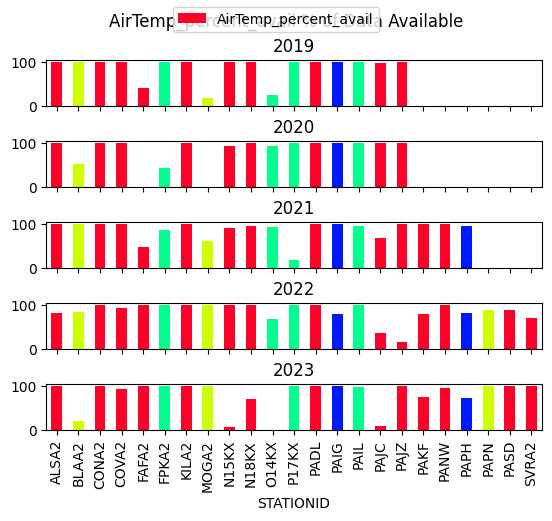

In [32]:
# # We want to see start year i.e. 2019, and our last visible year 2023
# startYear = 2019
# endYear = 2023
# yearRange = range(startYear,endYear+1)
# colormap = 'plasma'

# cmap = plt.get_cmap(colormap)
# # For Yearly coloring, divide colormap for the length of year range
# colors = [cmap(i / len(yearRange)) for i in range(len(yearRange))]
# # For by FIREZONE coloring, diving colormap by number of FIREZONE, assign to resulting colors.
# colors2 = [cmap(i / len(df_stats_tbl['Firezone'].unique())) for i in range(len(df_stats_tbl['Firezone'].unique()))]
# color_dict = dict(zip(df_stats_tbl['Firezone'].unique(), colors2))
# coloring_scheme = [color_dict.get(period) for period in station_firezone.values() ]
# print(coloring_scheme)

# fig, axs = plt.subplots(len(yearRange),1,sharex=True,sharey=True)
# for ax, year, color in zip(axs,yearRange,colors):
#   df_stats_tbl['AirTemp_percent_avail'][year].plot(ax=ax,kind='bar',title=year,fontsize=10,color=coloring_scheme)

# fig.subplots_adjust(hspace=0.75)
# fig.suptitle("Air Temperature % of Data Available")

# plt.show()

generateStats(2019,2023,'AirTemp_percent_avail')

[(0.050383, 0.029803, 0.527975, 1.0), (0.494877, 0.01199, 0.657865, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.798216, 0.280197, 0.469538, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.494877, 0.01199, 0.657865, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.798216, 0.280197, 0.469538, 1.0), (0.798216, 0.280197, 0.469538, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.973416, 0.585761, 0.25154, 1.0), (0.798216, 0.280197, 0.469538, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.973416, 0.585761, 0.25154, 1.0), (0.494877, 0.01199, 0.657865, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.050383, 0.029803, 0.527975, 1.0)]


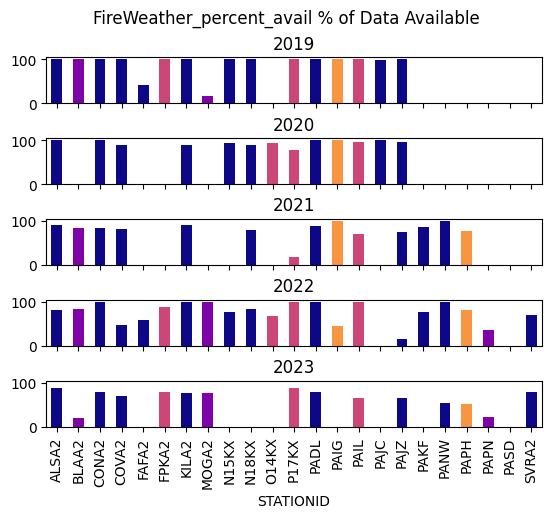

In [14]:
# fig, axs = plt.subplots(len(yearRange),1,sharex=True,sharey=True)
# for ax, year, color in zip(axs,yearRange,colors):
#   df_stats_tbl['FireWeather_percent_avail'][year].plot(ax=ax,kind='bar',title=year,fontsize=10,color=coloring_scheme)

# # Remove vertical space between axes
# fig.subplots_adjust(hspace=0.75)
# fig.suptitle("Fire Weather % of Data Available")

# plt.show()
generateStats(2019,2023,'FireWeather_percent_avail')

['ALSA2' 'BLAA2' 'CONA2' 'COVA2' 'FAFA2' 'FPKA2' 'KILA2' 'MOGA2' 'N15KX'
 'N18KX' 'O14KX' 'P17KX' 'PADL' 'PAIG' 'PAIL' 'PAJC' 'PAJZ' 'PAKF' 'PANW'
 'PAPH' 'PAPN' 'PASD' 'SVRA2']


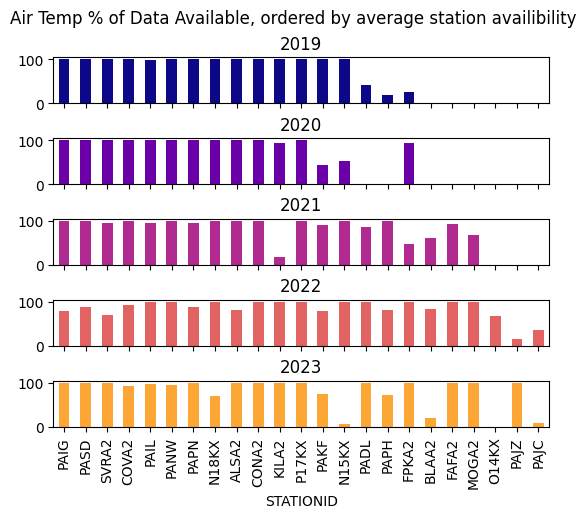

In [92]:
# TODO: Ensure Coloring is based on FIREZONE...
# Messes up Color Generation due to removing order of color calculation
# scign on stackoverflow https://stackoverflow.com/questions/23482668/sorting-by-a-custom-list-in-pandas
# helper function
def make_sorter(l):
    """
    Create a dict from the list to map to 0..len(l)
    Returns a mapper to map a series to this custom sort order
    """
    sort_order = {k:v for k,v in zip(l, range(len(l)))}
    return lambda s: s.map(lambda x: sort_order[x])

stations = df_stats_tbl.index.levels[1].values
station_percent_array = []
for station in stations:
  station_percent_array.append(df_stats_tbl.query(f'STATIONID == "{station}"')['AirTemp_percent_avail'].mean())
station_percent_dict = dict(zip(station_percent_array,stations))
station_percent_array.sort(reverse=True)
xLabels = [*map(station_percent_dict.get,station_percent_array)]



fig, axs = plt.subplots(len(yearRange),1,sharex=True,sharey=True)



df_stats_tbl = df_stats_tbl.sort_index(level=1,key=make_sorter(xLabels))
print(df_stats_tbl.index.levels[1].values)
for ax, year, color in zip(axs,yearRange,colors):

  fig.subplots_adjust(hspace=0.75)
  # Change color=coloring_scheme for firezone coloring, broken until figure out fix for changing order.....
  df_stats_tbl['AirTemp_percent_avail'][year].plot(ax=ax,kind='bar',title=year,fontsize=10,color=color)
  fig.suptitle("Air Temp % of Data Available, ordered by average station availibility")
